In [2]:
import pymc as pm


parameter = pm.Exponential("poisson_param", 1)
data_generator = pm.Poisson("data_generator", parameter)
data_plus_one = data_generator + 1


In [3]:
print "Children of `parameter`: "
print parameter.children
print "\nParents of `data_generator`: "
print data_generator.parents
print "\nChildren of `data_generator`: "
print data_generator.children

Children of `parameter`: 
set([<pymc.distributions.Poisson 'data_generator' at 0x10ba508d0>])

Parents of `data_generator`: 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x1048c00d0>}

Children of `data_generator`: 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x10ba50950>])


In [4]:
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)

In [5]:
lambda_1 = pm.Exponential("lambda_1", 1)  # prior on first behaviour
lambda_2 = pm.Exponential("lambda_2", 1)  # prior on second behaviour
tau = pm.DiscreteUniform("tau", lower=0, upper=10)  # prior on behaviour change

print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value
print

lambda_1.random(), lambda_2.random(), tau.random()

print "After calling random() on the variables..."
print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value

lambda_1.value = 0.450
lambda_2.value = 0.160
tau.value = 2.000

After calling random() on the variables...
lambda_1.value = 0.030
lambda_2.value = 0.512
tau.value = 0.000


In [6]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [7]:
import numpy as np
n_data_points = 5  # in CH1 we had ~70 data points


@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after tau is lambda2
    return out

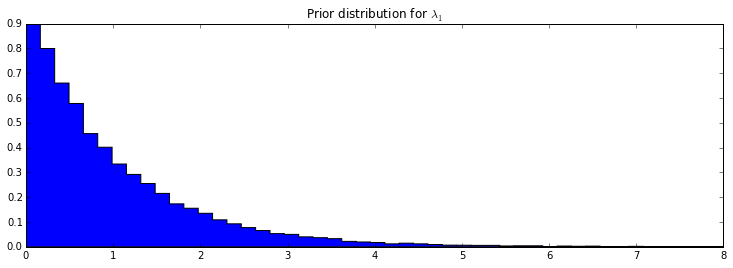

In [8]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)


samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

In [9]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print "value: ", fixed_variable.value
print "calling .random()"
fixed_variable.random()
print "value: ", fixed_variable.value

value:  [10  5]
calling .random()
value:  [10  5]


In [10]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print obs.value

[10 25 15 20 35]


In [11]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

In [12]:
tau = pm.rdiscrete_uniform(0, 80)
print tau

64


In [13]:
alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2

26.1059658405 8.99419705312


In [14]:
data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]

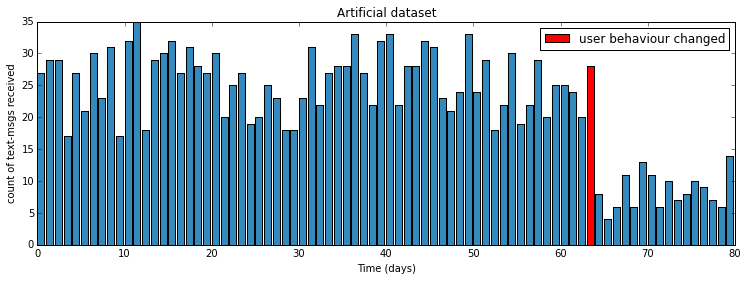

In [15]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

In [16]:
import pymc as pm

# The parameters are the bounds of the Uniform.
p = pm.Uniform('p', lower=0, upper=1)

In [17]:
# set constants
p_true = 0.05  # remember, this is unknown.
N = 3000

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = pm.rbernoulli(p_true, N)

print occurrences  # Remember: Python treats True == 1, and False == 0
print occurrences.sum()

[False False False ..., False False False]
139


In [18]:
# Occurrences.mean is equal to n/N.
print "What is the observed frequency in Group A? %.4f" % occurrences.mean()
print "Does this equal the true frequency? %s" % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0463
Does this equal the true frequency? False


In [19]:
# include the observations, which are Bernoulli
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# To be explained in chapter 3
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 1.6 sec

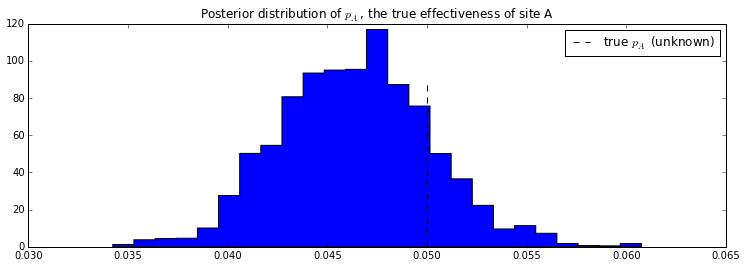

In [20]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend()

In [21]:
import pymc as pm
figsize(12, 4)

# these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

# generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Obs from Site A: ", observations_A[:30].astype(int), "..."
print "Obs from Site B: ", observations_B[:30].astype(int), "..."

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] ...


In [22]:
print observations_A.mean()
print observations_B.mean()

0.0473333333333
0.0413333333333


In [23]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# To be explained in chapter 3.
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 3.6 sec

In [24]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

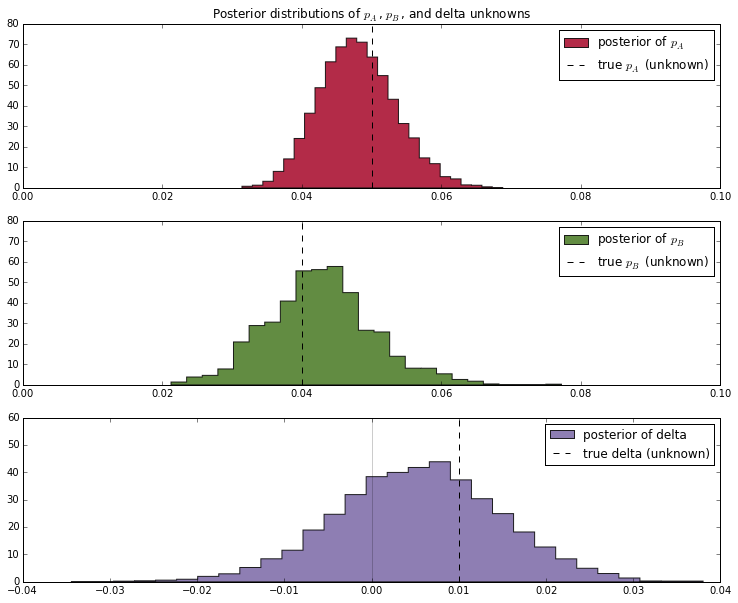

In [25]:
figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [26]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print "Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.284
Probability site A is BETTER than site B: 0.716


In [27]:
import pymc as pm

N = 100
p = pm.Uniform("freq_cheating", 0, 1)

In [28]:
true_answers = pm.Bernoulli("truths", p, size=N)

In [29]:
first_coin_flips = pm.Bernoulli("first_flips", 0.5, size=N)
print first_coin_flips.value

[ True False False  True  True  True False  True False  True  True  True
 False  True  True False  True  True False  True  True  True False  True
  True  True  True False  True  True False False False False False  True
  True False  True False  True False  True False False  True False  True
  True  True False  True False False False False  True False False False
 False False False False  True False False False  True  True False False
  True  True False  True  True False  True False  True  True False  True
 False  True  True False False False False False False False False  True
  True False  True False]


In [30]:
second_coin_flips = pm.Bernoulli("second_flips", 0.5, size=N)

In [31]:
@pm.deterministic
def observed_proportion(t_a=true_answers,
                        fc=first_coin_flips,
                        sc=second_coin_flips):

    observed = fc * t_a + (1 - fc) * sc
    return observed.sum() / float(N)

In [32]:
observed_proportion.value

0.58999999999999997

In [33]:
X = 35

observations = pm.Binomial("obs", N, observed_proportion, observed=True,
                           value=X)

In [34]:
model = pm.Model([p, true_answers, first_coin_flips,
                  second_coin_flips, observed_proportion, observations])

# To be explained in Chapter 3!
mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 18.6 sec

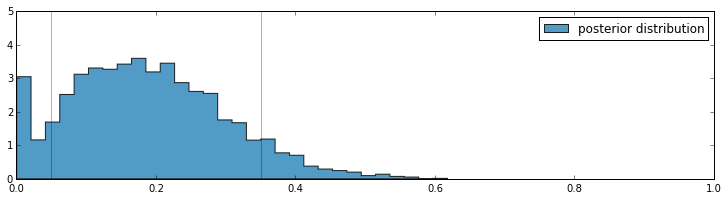

In [35]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

In [36]:
p = pm.Uniform("freq_cheating", 0, 1)


@pm.deterministic
def p_skewed(p=p):
    return 0.5 * p + 0.25

In [37]:
yes_responses = pm.Binomial("number_cheaters", 100, p_skewed,
                            value=35, observed=True)
print yes_responses

number_cheaters


In [38]:
print yes_responses.value

35


In [39]:
model = pm.Model([yes_responses, p_skewed, p])

# To Be Explained in Chapter 3!
mcmc = pm.MCMC(model)
mcmc.sample(25000, 2500)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.7 sec

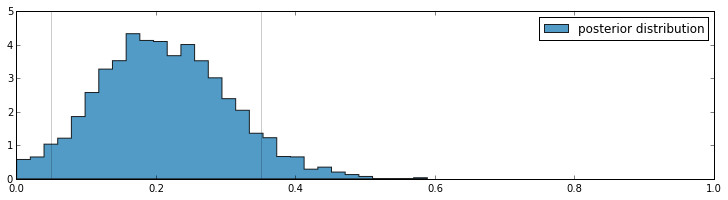

In [40]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

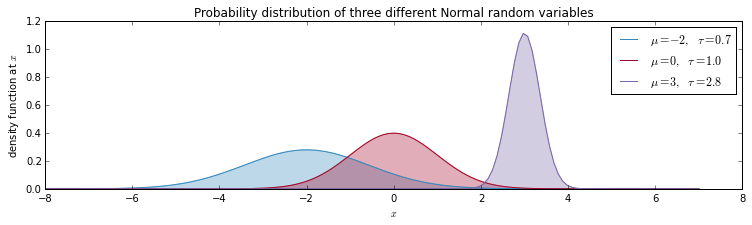

In [41]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1. / _tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1. / _tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


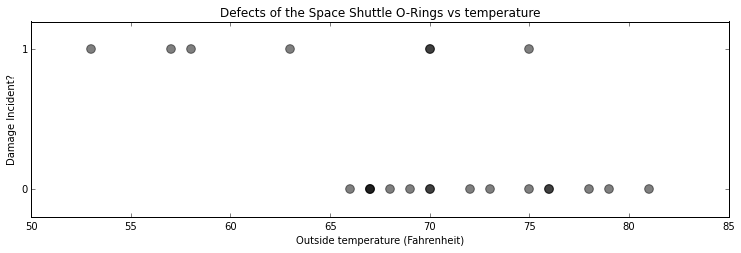

In [47]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print "Temp (F), O-Ring failure?"
print challenger_data

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")

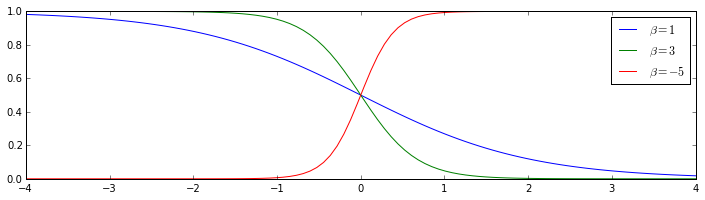

In [48]:
figsize(12, 3)


def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();

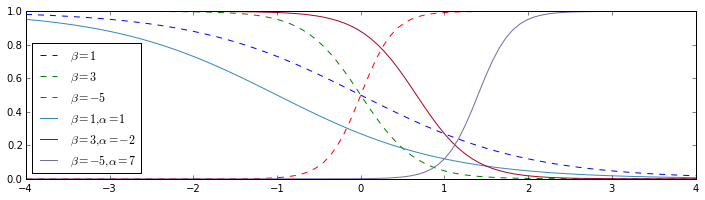

In [49]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

In [50]:
import pymc as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

# notice the`value` here. We explain why below.
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)


@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

In [51]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

In [52]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

# Mysterious code to be explained in Chapter 3
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 11.9 sec

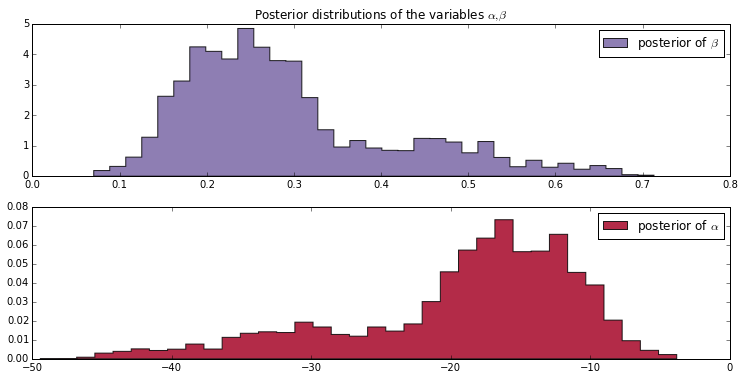

In [53]:
alpha_samples = mcmc.trace('alpha')[:, None]  # best to make them 1d
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [54]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

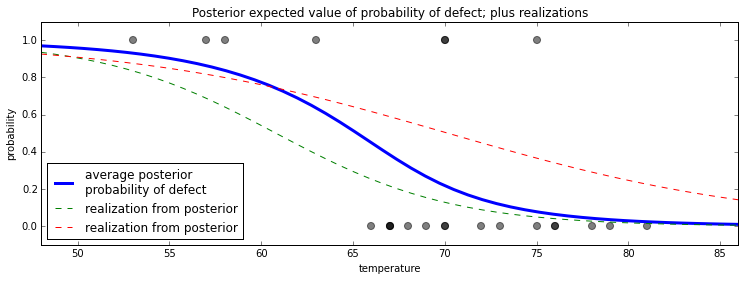

In [55]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

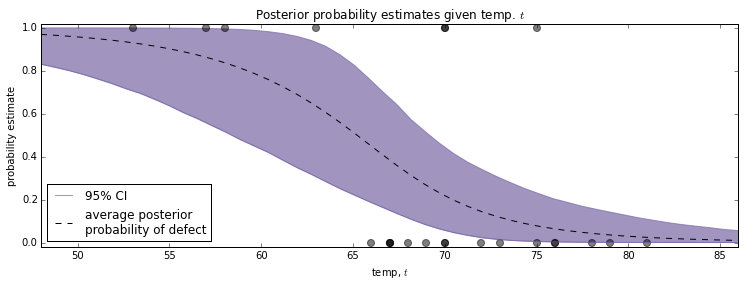

In [56]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

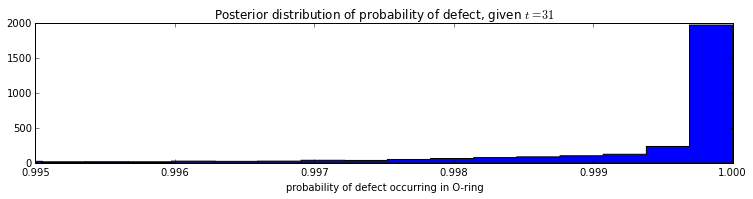

In [57]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

In [58]:
simulated = pm.Bernoulli("bernoulli_sim", p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec

In [59]:
simulated = pm.Bernoulli("bernoulli_sim", p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.1 sec

(10000, 23)


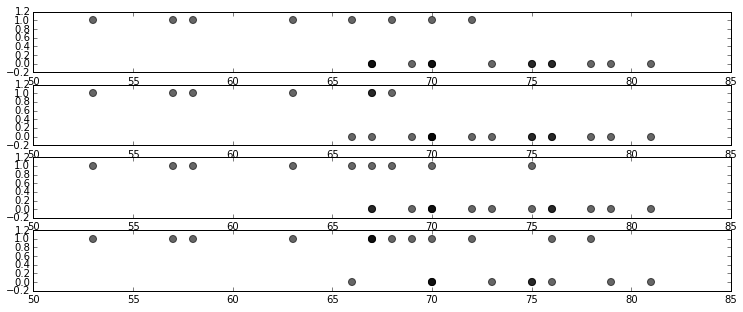

In [60]:
figsize(12.5, 5)

simulations = mcmc.trace("bernoulli_sim")[:]
print simulations.shape

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
    plt.scatter(temperature, simulations[1000 * i, :], color="k",
                s=50, alpha=0.6)